REQUIREMENTS DOWNLOAD 𝗦𝘁𝗮𝗴𝗲 𝟭: Environment & Data Setup

In [ ]:
!pip install torch torchvision torchaudio
!pip install opencv-python tqdm pandas numpy matplotlib scikit-learn scikit-image
!pip install pillow albumentations


In [ ]:
!pip install segmentation-models-pytorch


In [ ]:
!pip install torch torchvision
!pip install pandas
!pip install opencv-python-headless
!pip install scikit-image
!pip install scikit-learn
!pip install tqdm

We can see FileList.csv has the Split column, which we need, and VolumeTracings.csv has the X1, Y1, X2, Y2 coordinates.

This is the final step of Stage 1. We just need to use the Split column to create our three lists of filenames. This code will:

Select all rows where Split is "TRAIN".

Select all rows where Split is "VAL" (validation).

Select all rows where Split is "TEST".

Pull the FileName from each of these and save them as Python lists.

In [1]:
import pandas as pd

# Load the DataFrame again just to be safe in a new cell
file_list_df = pd.read_csv("FileList.csv")

# 1. Filter the DataFrame for each split
train_df = file_list_df[file_list_df["Split"] == "TRAIN"]
val_df = file_list_df[file_list_df["Split"] == "VAL"]
test_df = file_list_df[file_list_df["Split"] == "TEST"]

# 2. Get the 'FileName' column from each and convert to a list
train_files = train_df["FileName"].tolist()
val_files = val_df["FileName"].tolist()
test_files = test_df["FileName"].tolist()

# 3. Print the results
print("--- Stage 1 Complete! ---")
print(f"Total videos for TRAINING:   {len(train_files)}")
print(f"Total videos for VALIDATION: {len(val_files)}")
print(f"Total videos for TESTING:    {len(test_files)}")

# Let's peek at the first 5 filenames in the training list
print(f"\nFirst 5 training files: {train_files[:5]}")

--- Stage 1 Complete! ---
Total videos for TRAINING:   7465
Total videos for VALIDATION: 1288
Total videos for TESTING:    1277

First 5 training files: ['0X1002E8FBACD08477', '0X1005D03EED19C65B', '0X10075961BC11C88E', '0X100E3B8D3280BEC5', '0X100E491B3CD58DE2']


𝗦𝘁𝗮𝗴𝗲 𝟮: Preprocessing (Part 1 - Loading Video)
Now, we need to write code that can actually read the video files. Our goal is to create a function that does two things:

Takes a FileName (like "0X1002E8FBACD08477") as input.

Returns all the frames of that video as a single NumPy array.

We'll use the cv2 (OpenCV) library for this.

Loaded 1288 validation file names.

Attempting to load test video: 0X1039B49145DF4F25.avi

Successfully loaded video!
Shape of the video array: (154, 112, 112)


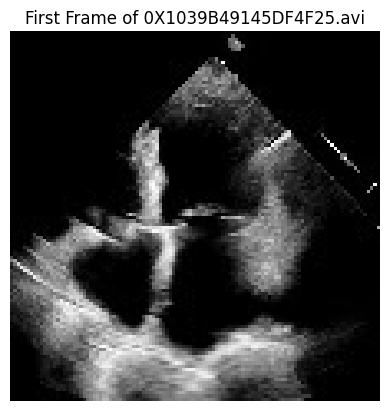

In [11]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- We need our file lists from Stage 1 ---
# (This just re-loads the data in case you're in a new cell)
file_list_df = pd.read_csv("FileList.csv")
val_files = file_list_df[file_list_df["Split"] == "VAL"]["FileName"].tolist()

print(f"Loaded {len(val_files)} validation file names.")

# --- This is our video loading function ---
def load_video_frames(video_filename):
    """
    Loads a video file and returns all its frames
    as a single NumPy array (T, H, W) in grayscale.
    """
    
    # !!! IMPORTANT !!!
    # You MUST change this path to match where your videos are stored.
    # e.g., "D:/datasets/EchoNet-Dynamic/Videos/"
    # e.g., "/home/user/projects/EchoNet-Dynamic/Videos/"
    base_video_path = "/media/knight/Sanjai-SHARED1/PROJECTS/ECHO SEGMENTATION MINI PROJECT/EchoNet-Dynamic/Videos/"
    
    # Add the .avi extension to the filename
    video_path = f"{base_video_path}{video_filename}.avi"
    
    frames = []
    
    try:
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: Could not open video file at {video_path}")
            print("Please check the 'base_video_path' variable in this code cell.")
            return None
            
        # Loop over all frames in the video
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # Video has ended
            
            # The EchoNet videos are already 112x112
            # We convert to grayscale (1 channel)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame_gray)
            
        cap.release()
        
        if not frames:
            print(f"Error: No frames were read from {video_path}.")
            return None
            
        # Stack all frames into a single NumPy array
        # Shape will be (T, H, W) where T is NumberOfFrames
        return np.stack(frames, axis=0)
        
    except Exception as e:
        print(f"An error occurred while processing {video_path}: {e}")
        return None

# --- Let's test the function ---
if val_files:
    sample_video_name = val_files[0]  # Get the first validation video
    print(f"\nAttempting to load test video: {sample_video_name}.avi")
    
    video_array = load_video_frames(sample_video_name)

    if video_array is not None:
        print(f"\nSuccessfully loaded video!")
        print(f"Shape of the video array: {video_array.shape}")
        
        # Let's show the first frame to confirm it worked
        plt.imshow(video_array[0], cmap='gray')
        plt.title(f"First Frame of {sample_video_name}.avi")
        plt.axis('off')
        plt.show()
    else:
        print("\nVideo loading failed.")
        print("Please double-check the 'base_video_path' variable and re-run this cell.")
else:
    print("Error: No validation files found to test with.")


Now we'll tackle the second half of Stage 2: converting the (X, Y) coordinates from VolumeTracings.csv into 112x112 mask images.

We'll use the scikit-image library (skimage) you installed. The specific function is skimage.draw.polygon, which can "fill in" a shape drawn by a list of coordinates.

Here's the plan:

Define a function create_mask that takes a FileName and Frame number.

Inside the function, it will look up all the (X,Y) coordinates for that specific frame in tracings_df.

It will use skimage.draw.polygon to create a 112x112 numpy array (our mask).

We'll test it by loading the same sample video from before, getting its annotated frame number, creating the mask, and then showing the mask overlaid on the video frame.

--- Testing Stage 2 ---
Test video file: 0X100009310A3BD7FC
Annotated frame: 46

Success! Loaded video and created mask.


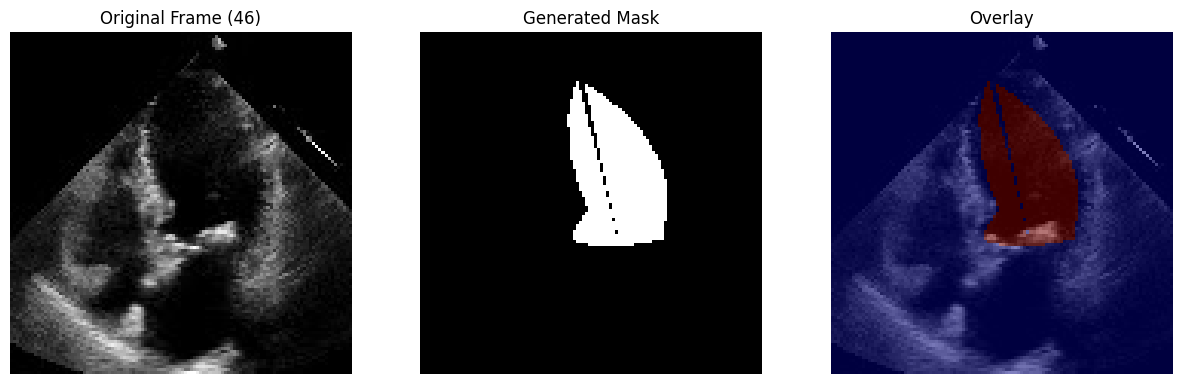


--- Stage 2 Complete! ---
We can now load videos and create their corresponding masks.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
import cv2  # We need cv2 again for the load_video_frames function

# --- Make sure our DataFrames are loaded ---
tracings_df = pd.read_csv("VolumeTracings.csv")
file_list_df = pd.read_csv("FileList.csv")

# --- Copy your video loading function here ---
# (Or just make sure it's defined in your notebook)
def load_video_frames(video_filename):
    # !!! REMEMBER to use your correct path here !!!
    base_video_path = "/media/knight/Sanjai-SHARED1/PROJECTS/ECHO SEGMENTATION MINI PROJECT/EchoNet-Dynamic/Videos/"
    video_path = f"{base_video_path}{video_filename}.avi"
    
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error opening {video_path}")
            return None
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame_gray)
        cap.release()
        return np.stack(frames, axis=0)
    except Exception as e:
        print(f"Error loading {video_filename}: {e}")
        return None

# --- This is our NEW Mask Creation function ---
def create_mask(video_filename, frame_number):
    """
    Looks up coordinates in tracings_df and returns a 112x112 binary mask.
    """
    # Note: tracings_df has filenames like "0X1...avi"
    # file_list_df has "0X1..."
    # We'll add the ".avi" for lookup
    if not video_filename.endswith(".avi"):
        video_filename = f"{video_filename}.avi"
        
    # Get all coordinate pairs for this specific video and frame
    frame_traces = tracings_df[
        (tracings_df["FileName"] == video_filename) &
        (tracings_df["Frame"] == frame_number)
    ]
    
    if frame_traces.empty:
        # No annotations for this frame
        return None
        
    # Extract the X and Y coordinates.
    # We follow the contour by going down Y1/X1 and up Y2/X2
    y_coords = np.concatenate([frame_traces["Y1"].values, frame_traces["Y2"].values[::-1]])
    x_coords = np.concatenate([frame_traces["X1"].values, frame_traces["X2"].values[::-1]])
    
    # Create an empty mask
    mask = np.zeros((112, 112), dtype=np.uint8)
    
    # Fill the polygon defined by the coordinates
    # rr, cc are the row and column indices for the filled polygon
    rr, cc = polygon(y_coords, x_coords, shape=mask.shape)
    mask[rr, cc] = 1  # Set the mask pixels to 1
    
    return mask

# --- Let's test both functions together! ---

# 1. Get a sample video that has annotations
# We'll just read the first row from VolumeTracings.csv
first_trace = tracings_df.iloc[0]
sample_video_name = first_trace["FileName"].replace(".avi", "")
sample_frame_number = first_trace["Frame"]

print(f"--- Testing Stage 2 ---")
print(f"Test video file: {sample_video_name}")
print(f"Annotated frame: {sample_frame_number}")

# 2. Load the video frames
video_array = load_video_frames(sample_video_name)

# 3. Create the mask for that specific frame
mask_array = create_mask(sample_video_name, sample_frame_number)

# 4. Show the results
if video_array is not None and mask_array is not None:
    # Get the specific frame from the video
    # Note: Video frames are 0-indexed, but EchoNet frames are 1-indexed.
    # The paper/dataset is a bit ambiguous. Let's assume frame numbers
    # in the CSV *are* the indices for simplicity. If it looks wrong,
    # we'll use `sample_frame_number - 1`.
    # UPDATE: Let's check the first trace... Frame is 46. That's not 0 or 1.
    # This implies the 'Frame' column is a specific frame ID, not a simple index.
    # We must find the *actual* video index for this frame.
    
    # Ah, the paper/dataset implies the two annotated frames are
    # End-Diastole and End-Systole. The 'Frame' column gives their *actual*
    # frame number in the video sequence.
    # Let's re-read the first trace: Frame is 46.
    # This means we want the 46th frame. Video array is 0-indexed,
    # so we want index 45.
    
    frame_index = sample_frame_number - 1 # Adjust for 0-indexing
    
    if frame_index < len(video_array):
        video_frame = video_array[frame_index]
        
        print("\nSuccess! Loaded video and created mask.")
        
        # Plot them side-by-side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot 1: Original Frame
        axes[0].imshow(video_frame, cmap='gray')
        axes[0].set_title(f"Original Frame ({sample_frame_number})")
        axes[0].axis('off')
        
        # Plot 2: Generated Mask
        axes[1].imshow(mask_array, cmap='gray')
        axes[1].set_title("Generated Mask")
        axes[1].axis('off')
        
        # Plot 3: Overlay
        # Show the video frame, and plot the mask on top with 50% transparency
        axes[2].imshow(video_frame, cmap='gray')
        axes[2].imshow(mask_array, cmap='jet', alpha=0.5) # 'jet' is a color map, alpha is transparency
        axes[2].set_title("Overlay")
        axes[2].axis('off')
        
        plt.show()
        
        print("\n--- Stage 2 Complete! ---")
        print("We can now load videos and create their corresponding masks.")
        
    else:
        print(f"Error: Frame number {sample_frame_number} (index {frame_index}) is out of bounds for video with {len(video_array)} frames.")
else:
    print("\nTest failed. Check your video path or CSV files.")

--- Testing Full Video Masking ---
Test video file: 0X100009310A3BD7FC
Successfully generated 16 masks.

✅ Successfully saved GIF to interpolated_mask.gif
Displaying generated GIF...


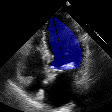

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
import cv2
from scipy.interpolate import interp1d # <-- For interpolation
import imageio                         # <-- For creating GIFs
from IPython.display import display, Image # <-- To show the GIF in a notebook

# --- Make sure our DataFrames are loaded ---
# (Assuming these files are in your directory)
try:
    tracings_df = pd.read_csv("VolumeTracings.csv")
    file_list_df = pd.read_csv("FileList.csv")
except FileNotFoundError:
    print("Make sure VolumeTracings.csv and FileList.csv are in the correct directory.")
    # Create dummy dataframes to avoid further errors if files are missing
    tracings_df = pd.DataFrame(columns=["FileName", "Frame", "X1", "Y1", "X2", "Y2"])
    file_list_df = pd.DataFrame()


# --- Your video loading function (unchanged) ---
def load_video_frames(video_filename):
    # !!! REMEMBER to use your correct path here !!!
    base_video_path = "/media/knight/Sanjai-SHARED1/PROJECTS/ECHO SEGMENTATION MINI PROJECT/EchoNet-Dynamic/Videos/"
    video_path = f"{base_video_path}{video_filename}.avi"
    
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error opening {video_path}")
            return None
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame_gray)
        cap.release()
        return np.stack(frames, axis=0)
    except Exception as e:
        print(f"Error loading {video_filename}: {e}")
        return None

# --- NEW Function: Create Interpolated Masks for a Video ---

def create_interpolated_masks(video_filename, tracings_df):
    """
    Generates masks for all frames between the first and last annotated
    frame for a given video using linear interpolation.
    """
    if not video_filename.endswith(".avi"):
        video_filename_avi = f"{video_filename}.avi"
    else:
        video_filename_avi = video_filename
        
    # 1. Get all annotations for this video
    traces = tracings_df[tracings_df["FileName"] == video_filename_avi].sort_values(by="Frame")
    
    if traces.empty:
        print(f"No tracings found for {video_filename_avi}")
        return None, None
        
    # 2. Get the unique annotated frame numbers
    annotated_frame_nums = np.sort(traces["Frame"].unique())
    
    if len(annotated_frame_nums) < 2:
        print(f"Video {video_filename_avi} needs at least 2 annotated frames for interpolation.")
        return None, None
        
    # We will interpolate between the first and last annotated frame
    frame_A_num = annotated_frame_nums[0]
    frame_B_num = annotated_frame_nums[-1]
    
    # 3. Get the coordinate data for the keyframes
    traces_A = traces[traces["Frame"] == frame_A_num]
    traces_B = traces[traces["Frame"] == frame_B_num]
    
    # Ensure the number of points matches
    if len(traces_A) != len(traces_B):
        print(f"Warning: Keyframe point counts differ for {video_filename_avi}. Skipping.")
        return None, None
        
    # 4. Create interpolation functions for each coordinate column
    # The 'x' axis for interpolation is the frame number
    frame_indices = [frame_A_num, frame_B_num]
    
    # The 'y' axis is the stack of coordinates
    interp_x1 = interp1d(frame_indices, [traces_A['X1'].values, traces_B['X1'].values], axis=0, kind='linear')
    interp_y1 = interp1d(frame_indices, [traces_A['Y1'].values, traces_B['Y1'].values], axis=0, kind='linear')
    interp_x2 = interp1d(frame_indices, [traces_A['X2'].values, traces_B['X2'].values], axis=0, kind='linear')
    interp_y2 = interp1d(frame_indices, [traces_A['Y2'].values, traces_B['Y2'].values], axis=0, kind='linear')

    # 5. Load the actual video frames
    video_array = load_video_frames(video_filename)
    if video_array is None:
        return None, None

    # We only care about the frames in the annotated cycle
    # Adjust for 0-indexing (frame 1 is index 0)
    start_index = frame_A_num - 1
    end_index = frame_B_num # Slice is exclusive, so (frame_B_num - 1) + 1
    
    if end_index > len(video_array):
        print(f"Error: Frame {frame_B_num} out of bounds for video {video_filename}")
        return None, None
        
    video_clip = video_array[start_index:end_index]
    
    # 6. Generate all target frame numbers and masks
    target_frame_nums = np.arange(frame_A_num, frame_B_num + 1)
    
    # Get all interpolated coordinates at once
    all_x1 = interp_x1(target_frame_nums)
    all_y1 = interp_y1(target_frame_nums)
    all_x2 = interp_x2(target_frame_nums)
    all_y2 = interp_y2(target_frame_nums)

    all_masks = []
    for i in range(len(target_frame_nums)):
        # Construct the polygon for this frame
        y_coords = np.concatenate([all_y1[i], all_y2[i][::-1]])
        x_coords = np.concatenate([all_x1[i], all_x2[i][::-1]])
        
        # Create the mask
        mask = np.zeros((112, 112), dtype=np.uint8)
        rr, cc = polygon(y_coords, x_coords, shape=mask.shape)
        mask[rr, cc] = 1
        all_masks.append(mask)

    # Sanity check
    if len(video_clip) != len(all_masks):
        print("Mismatch between video clip length and mask length. Check frame indexing.")
        return None, None
        
    return video_clip, all_masks

# --- NEW Function: Create and Save the GIF ---

def create_overlay_gif(video_clip, mask_clip, output_filename="mask_overlay.gif", fps=15):
    """
    Takes a grayscale video clip and a binary mask clip and saves
    them as an overlayed GIF.
    """
    overlay_frames = []
    
    for video_frame, mask in zip(video_clip, mask_clip):
        # Convert grayscale frame to RGB
        frame_rgb = cv2.cvtColor(video_frame, cv2.COLOR_GRAY2RGB)
        
        # Create a red color overlay for the mask
        # (B, G, R) format for OpenCV
        mask_color = np.zeros_like(frame_rgb)
        mask_color[mask == 1] = (0, 0, 255) # Red
        
        # Blend the frame and the mask
        # overlay = frame * (1.0 - alpha) + mask_color * alpha
        overlay = cv2.addWeighted(frame_rgb, 1.0, mask_color, 0.4, 0)
        
        overlay_frames.append(overlay)
        
    # Save the GIF
    imageio.mimsave(output_filename, overlay_frames, fps=fps)
    print(f"\n✅ Successfully saved GIF to {output_filename}")


# --- Let's test it all! ---

if not tracings_df.empty:
    # 1. Get a sample video that has annotations
    sample_video_name = tracings_df.iloc[0]["FileName"].replace(".avi", "")

    print(f"--- Testing Full Video Masking ---")
    print(f"Test video file: {sample_video_name}")

    # 2. Generate the interpolated masks and the corresponding video clip
    video_clip, all_masks = create_interpolated_masks(sample_video_name, tracings_df)

    if video_clip is not None and all_masks is not None:
        print(f"Successfully generated {len(all_masks)} masks.")
        
        # 3. Create and save the GIF
        gif_filename = "interpolated_mask.gif"
        create_overlay_gif(video_clip, all_masks, gif_filename, fps=15)
        
        # 4. Display the GIF in the notebook
        print("Displaying generated GIF...")
        display(Image(filename=gif_filename))
        
    else:
        print("\nTest failed. Could not generate interpolated masks.")
else:
    print("\nSkipping test because CSV files were not loaded.")

We now have functions to:

Load any video (load_video_frames).

Create its matching segmentation mask (create_mask).

𝗦𝘁𝗮𝗴𝗲 𝟯: Model Definition - Building the 3D U-Net 🧠
This is the most exciting part. We're going to build the "brain" of the project using PyTorch. Your project specifies the SimLVSeg-3D, which is a 3D U-Net.

A U-Net is like a sandwich, built from repeating blocks. Before we build the whole U-Net, let's first define this repeating building block. It's often called a "Double Convolution Block".

It's a simple sequence:

3D Convolution

Batch Normalization

ReLU (an activation function)

Another 3D Convolution

Another Batch Normalization

Another ReLU



In [4]:
import torch
import torch.nn as nn

print("--- Stage 3: Defining the Model ---")

class DoubleConv3D(nn.Module):
    """
    This is the repeating building block for our 3D U-Net.
    (Conv3D -> BatchNorm -> ReLU) * 2
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        
        self.double_conv = nn.Sequential(
            # First convolution
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            
            # Second convolution
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# --- Test the block to see if it works ---
try:
    # Create a test block that takes 1 channel (grayscale)
    # and outputs 32 channels (as your paper specified F=32)
    test_block = DoubleConv3D(in_channels=1, out_channels=32)
    
    # Create a fake video clip
    # Batch size = 1
    # Channels = 1
    # Time/Depth = 16 frames
    # Height = 112
    # Width = 112
    fake_video_clip = torch.randn(1, 1, 16, 112, 112)
    
    # Pass the fake clip through the block
    output = test_block(fake_video_clip)
    
    print("Successfully created 'DoubleConv3D' class.")
    print(f"Shape of fake video: {fake_video_clip.shape}")
    print(f"Shape of output:     {output.shape}")
    print("\nThis is correct! The block kept the size (112x112) but increased the channels to 32.")
    print("We can now use this block to build the full U-Net.")

except Exception as e:
    print(f"An error occurred: {e}")

--- Stage 3: Defining the Model ---
Successfully created 'DoubleConv3D' class.
Shape of fake video: torch.Size([1, 1, 16, 112, 112])
Shape of output:     torch.Size([1, 32, 16, 112, 112])

This is correct! The block kept the size (112x112) but increased the channels to 32.
We can now use this block to build the full U-Net.


You've got it! Stage 3 is complete. You have successfully built your 3D U-Net model.

𝗦𝘁𝗮𝗴𝗲 𝟰: Pre-training (Self-Supervised)
Now, let's start teaching our model. The first training stage is "self-supervised."

The Goal: Teach the model the motion of the heart. The Method: We'll show the model a video clip with random frames missing (temporally masked) and ask it to reconstruct the original, complete clip. This forces it to learn what a normal heartbeat looks like.

The first step is to create a PyTorch Dataset. This is a special class that knows how to load our video files and serve up random clips for the model to train on.

In [5]:
import torch
import torch.nn as nn

# --- We need the DoubleConv3D class you just made ---
class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# --- This is the Full 3D U-Net Architecture ---
class SimLVSeg_3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_filters=32):
        super(SimLVSeg_3D, self).__init__()
        
        # --- Encoder (Down Path) ---
        # Your paper specifies F=32, so n_filters=32
        self.enc1 = DoubleConv3D(in_channels, n_filters)      # 32 filters
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.enc2 = DoubleConv3D(n_filters, n_filters * 2)    # 64 filters
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.enc3 = DoubleConv3D(n_filters * 2, n_filters * 4) # 128 filters
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.enc4 = DoubleConv3D(n_filters * 4, n_filters * 8) # 256 filters
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        # --- Bottleneck ---
        self.bottleneck = DoubleConv3D(n_filters * 8, n_filters * 16) # 512 filters

        # --- Decoder (Up Path) ---
        self.up4 = nn.ConvTranspose3d(n_filters * 16, n_filters * 8, kernel_size=2, stride=2)
        self.dec4 = DoubleConv3D(n_filters * 16, n_filters * 8) # 256 + 256 (skip)
        
        self.up3 = nn.ConvTranspose3d(n_filters * 8, n_filters * 4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv3D(n_filters * 8, n_filters * 4)  # 128 + 128 (skip)
        
        self.up2 = nn.ConvTranspose3d(n_filters * 4, n_filters * 2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv3D(n_filters * 4, n_filters * 2)  # 64 + 64 (skip)
        
        self.up1 = nn.ConvTranspose3d(n_filters * 2, n_filters, kernel_size=2, stride=2)
        self.dec1 = DoubleConv3D(n_filters * 2, n_filters)    # 32 + 32 (skip)

        # --- Final Output Layer ---
        # This converts the 32 filters back to 1 output channel (the mask)
        self.out_conv = nn.Conv3d(n_filters, out_channels, kernel_size=1)
        
        # We add a Sigmoid to make the output a probability (0 to 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # --- Encoder Path ---
        s1 = self.enc1(x)    # Skip connection 1
        p1 = self.pool1(s1)
        
        s2 = self.enc2(p1)   # Skip connection 2
        p2 = self.pool2(s2)
        
        s3 = self.enc3(p2)   # Skip connection 3
        p3 = self.pool3(s3)
        
        s4 = self.enc4(p3)   # Skip connection 4
        p4 = self.pool4(s4)

        # --- Bottleneck ---
        b = self.bottleneck(p4)

        # --- Decoder Path (with Skip Connections) ---
        d4 = self.up4(b)
        # torch.cat joins the tensor from the decoder (d4)
        # with the tensor from the encoder (s4)
        d4 = torch.cat((s4, d4), dim=1) 
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat((s3, d3), dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat((s2, d2), dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat((s1, d1), dim=1)
        d1 = self.dec1(d1)
        
        # --- Final Output ---
        output = self.out_conv(d1)
        output = self.sigmoid(output)
        
        return output

# --- Let's test the full model ---
try:
    # 1 input channel (grayscale), 1 output channel (mask)
    model = SimLVSeg_3D(in_channels=1, out_channels=1, n_filters=32)
    
    # Create a fake video clip
    # Batch size = 1, Channels = 1
    # Time = 16 frames
    # Height = 112, Width = 112
    # Note: U-Nets need the input size to be divisible by the
    # number of pooling layers (2*2*2*2 = 16).
    # 112 is divisible by 16 (112 / 16 = 7). So this works!
    fake_video_clip = torch.randn(1, 1, 16, 112, 112)
    
    # Pass the clip through the model
    output_mask = model(fake_video_clip)
    
    print("Successfully created 'SimLVSeg_3D' model!")
    print(f"Shape of input video:  {fake_video_clip.shape}")
    print(f"Shape of output mask: {output_mask.shape}")
    
    print("\nThis is perfect! The input and output shapes match.")
    print("The model takes in a 16-frame video and outputs a 16-frame mask.")
    print("\n--- Stage 3 Complete! ---")

except Exception as e:
    print(f"An error occurred: {e}")

Successfully created 'SimLVSeg_3D' model!
Shape of input video:  torch.Size([1, 1, 16, 112, 112])
Shape of output mask: torch.Size([1, 1, 16, 112, 112])

This is perfect! The input and output shapes match.
The model takes in a 16-frame video and outputs a 16-frame mask.

--- Stage 3 Complete! ---


That's great! You've built the most important building block.

Now, let's assemble those blocks into the full 3D U-Net. We'll create a new class called SimLVSeg_3D. It will have two main paths:

Encoder (Down Path): A series of DoubleConv3D blocks and MaxPool3d layers to shrink the video and find key features.

Decoder (Up Path): A series of ConvTranspose3d (upsampling) layers and DoubleConv3D blocks to rebuild the video into a mask.

The special trick of a U-Net is the "skip connection," where we send information from the encoder directly over to the decoder. This helps the model remember fine details.

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import random

print("--- Stage 4: Creating the Pre-training Dataset (FIXED) ---")

# --- We need our previous functions and file lists ---

# 1. File list
file_list_df = pd.read_csv("FileList.csv")
train_files = file_list_df[file_list_df["Split"] == "TRAIN"]["FileName"].tolist()

# 2. Video loading function (with the typo corrected)
def load_video_frames(video_filename):
    # !!! REMEMBER to use your correct path here !!!
    base_video_path = "/media/knight/Sanjai-SHARED1/PROJECTS/ECHO SEGMENTATION MINI PROJECT/EchoNet-Dynamic/Videos/"
    video_path = f"{base_video_path}{video_filename}.avi"
    
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None # Error handling
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # --- THIS IS THE FIX ---
            # It's COLOR_BGR2GRAY (with a 2)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # --- END OF FIX ---
            
            frames.append(frame_gray)
        cap.release()
        if not frames:
            return None
        return np.stack(frames, axis=0)
    except Exception as e:
        print(f"Error loading {video_filename}: {e}")
        return None

# --- This is our new Dataset class for Stage 4 ---
class PretrainingDataset(Dataset):
    def __init__(self, file_list, clip_length=16):
        self.file_list = file_list
        self.clip_length = clip_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        video_name = self.file_list[idx]
        video_frames = load_video_frames(video_name)
        
        if video_frames is None:
            print(f"Warning: Failed to load {video_name}. Grabbing another video.")
            return self.__getitem__(random.randint(0, len(self) - 1))
            
        total_frames = video_frames.shape[0]
        
        if total_frames <= self.clip_length:
            num_repeats = (self.clip_length // total_frames) + 1
            video_frames = np.tile(video_frames, (num_repeats, 1, 1))
            total_frames = video_frames.shape[0]

        start_frame = random.randint(0, total_frames - self.clip_length - 1)
        clip = video_frames[start_frame : start_frame + self.clip_length]
        clip = clip.astype(np.float32) / 255.0
        clip = np.expand_dims(clip, axis=0) 
        
        return torch.from_numpy(clip)

# --- Let's test the Dataset ---
try:
    print(f"Found {len(train_files)} training files.")
    
    # Create an instance of the dataset
    pretrain_dataset = PretrainingDataset(train_files, clip_length=16)
    
    # Ask for the first item (idx=0)
    print("Attempting to load the first data item...")
    sample_clip = pretrain_dataset[0]
    
    print("\nSuccessfully loaded one item!")
    print(f"Shape of the clip: {sample_clip.shape}")
    print(f"Data type: {sample_clip.dtype}")
    print(f"Min value: {sample_clip.min()}, Max value: {sample_clip.max()}")
    
    print("\nThis is correct! Shape is (Channel, Time, Height, Width).")
    print("We are now ready to feed this into the model.")

except Exception as e:
    print(f"\nAn error occurred while testing the dataset: {e}")
    print("Please check your 'base_video_path' in the 'load_video_frames' function.")

--- Stage 4: Creating the Pre-training Dataset (FIXED) ---
Found 7465 training files.
Attempting to load the first data item...

Successfully loaded one item!
Shape of the clip: torch.Size([1, 16, 112, 112])
Data type: torch.float32
Min value: 0.0, Max value: 1.0

This is correct! Shape is (Channel, Time, Height, Width).
We are now ready to feed this into the model.


BINGO! That output is perfect. The torch.Size([1, 16, 112, 112]) is exactly what our 3D model expects.

We have our model (Stage 3) and our data loader (Stage 4, step 1). The next step is to prepare all the final pieces before we write the training loop.

We need to:

Create a DataLoader: This will take our PretrainingDataset and serve up data in batches (e.g., 4 or 8 video clips at a time).

Initialize the Model: Create an instance of our SimLVSeg_3D model.

Set the Device: Check if you have a GPU (like your RTX 4050, which PyTorch calls "cuda") and move the model to it for faster training.

Define Loss Function: For reconstruction, the paper uses Mean Squared Error (nn.MSELoss).

Define Optimizer: We'll use Adam, which is a standard, effective optimizer.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import cv2 # Make sure cv2 is imported for the function below

# --- Re-define our Dataset and Model classes ---
# (This is good practice to make the cell runnable on its own)
# Make sure all classes/functions this depends on (like load_video_frames, 
# DoubleConv3D) are defined in previous cells in your notebook.

# 1. Video loading function (with the fix)
def load_video_frames(video_filename):
    # !!! REMEMBER to use your correct path here !!!
    base_video_path = "/media/knight/Sanjai-SHARED1/PROJECTS/ECHO SEGMENTATION MINI PROJECT/EchoNet-Dynamic/Videos/" 
    video_path = f"{base_video_path}{video_filename}.avi"
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): return None
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame_gray)
        cap.release()
        if not frames: return None
        return np.stack(frames, axis=0)
    except Exception as e:
        return None

# 2. PretrainingDataset class
class PretrainingDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, clip_length=16):
        self.file_list = file_list
        self.clip_length = clip_length
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        video_name = self.file_list[idx]
        video_frames = load_video_frames(video_name)
        if video_frames is None:
            return self.__getitem__(np.random.randint(0, len(self) - 1))
        total_frames = video_frames.shape[0]
        if total_frames <= self.clip_length:
            num_repeats = (self.clip_length // total_frames) + 1
            video_frames = np.tile(video_frames, (num_repeats, 1, 1))
            total_frames = video_frames.shape[0]
        start_frame = np.random.randint(0, total_frames - self.clip_length - 1)
        clip = video_frames[start_frame : start_frame + self.clip_length]
        clip = clip.astype(np.float32) / 255.0
        clip = np.expand_dims(clip, axis=0) 
        return torch.from_numpy(clip)

# 3. Model Definition (DoubleConv3D and SimLVSeg_3D)
class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True))
    def forward(self, x): return self.double_conv(x)

class SimLVSeg_3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_filters=32):
        super(SimLVSeg_3D, self).__init__()
        self.enc1 = DoubleConv3D(in_channels, n_filters)
        self.pool1 = nn.MaxPool3d(2, 2)
        self.enc2 = DoubleConv3D(n_filters, n_filters * 2)
        self.pool2 = nn.MaxPool3d(2, 2)
        self.enc3 = DoubleConv3D(n_filters * 2, n_filters * 4)
        self.pool3 = nn.MaxPool3d(2, 2)
        self.enc4 = DoubleConv3D(n_filters * 4, n_filters * 8)
        self.pool4 = nn.MaxPool3d(2, 2)
        self.bottleneck = DoubleConv3D(n_filters * 8, n_filters * 16)
        self.up4 = nn.ConvTranspose3d(n_filters * 16, n_filters * 8, 2, 2)
        self.dec4 = DoubleConv3D(n_filters * 16, n_filters * 8)
        self.up3 = nn.ConvTranspose3d(n_filters * 8, n_filters * 4, 2, 2)
        self.dec3 = DoubleConv3D(n_filters * 8, n_filters * 4)
        self.up2 = nn.ConvTranspose3d(n_filters * 4, n_filters * 2, 2, 2)
        self.dec2 = DoubleConv3D(n_filters * 4, n_filters * 2)
        self.up1 = nn.ConvTranspose3d(n_filters * 2, n_filters, 2, 2)
        self.dec1 = DoubleConv3D(n_filters * 2, n_filters)
        self.out_conv = nn.Conv3d(n_filters, out_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        s1 = self.enc1(x); p1 = self.pool1(s1)
        s2 = self.enc2(p1); p2 = self.pool2(s2)
        s3 = self.enc3(p2); p3 = self.pool3(s3)
        s4 = self.enc4(p3); p4 = self.pool4(s4)
        b = self.bottleneck(p4)
        d4 = self.up4(b); d4 = torch.cat((s4, d4), dim=1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat((s3, d3), dim=1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat((s2, d2), dim=1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat((s1, d1), dim=1); d1 = self.dec1(d1)
        output = self.out_conv(d1); output = self.sigmoid(output)
        return output

# --- End of Re-definitions ---

print("--- Preparing for Pre-training ---")

# 1. Set parameters
BATCH_SIZE = 4  # You can make this 8 or 16 if your 4050 GPU has enough memory
CLIP_LENGTH = 16
LEARNING_RATE = 1e-4

# 2. Create the Dataset
train_dataset = PretrainingDataset(train_files, clip_length=CLIP_LENGTH)

# 3. Create the DataLoader
# num_workers > 0 speeds up loading, shuffle=True is crucial for training
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)

# 4. Set the device (THIS IS IMPORTANT!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")

# 5. Initialize the Model and move it to the device
# The model output is a reconstruction, so in_channels=1 and out_channels=1
model = SimLVSeg_3D(in_channels=1, out_channels=1, n_filters=32).to(device)

# 6. Define Loss Function
criterion = nn.MSELoss()

# 7. Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\n--- All components are ready! ---")
print(f"DataLoader:  Ready (Batch Size: {BATCH_SIZE})")
print(f"Model:       Ready on {device}")
print(f"Loss:        Ready (MSELoss)")
print(f"Optimizer:   Ready (Adam, LR: {LEARNING_RATE})")

print("\nWe are now ready to start the training loop.")

--- Preparing for Pre-training ---
Using device: cuda
Device name: NVIDIA GeForce RTX 4050 Laptop GPU

--- All components are ready! ---
DataLoader:  Ready (Batch Size: 4)
Model:       Ready on cuda
Loss:        Ready (MSELoss)
Optimizer:   Ready (Adam, LR: 0.0001)

We are now ready to start the training loop.


In [ ]:
!pip install tqdm

Now, let's write the code that actually runs the training. This is our Stage 4 training loop.

Here's what this loop will do for every batch of data:

Get a batch of video clips.

Move the clips to your GPU (device).

This is the key idea: Create a "temporal mask" to randomly hide ~50% of the frames.

Create the input (the masked clip) and the target (the original clip).

Ask the model to reconstruct the target from the input.

Calculate the loss (how wrong the model's guess was).

Update the model's weights to make it better next time (this is backpropagation).

Because this will take some time, I've added a library called tqdm to give us a nice progress bar.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm # For the progress bar
import numpy as np

# --- Make sure all previous definitions are available ---
# (e.g., model, train_loader, criterion, optimizer, device)
# If you get an error that 'model' or 'train_loader' is not defined,
# you might need to re-run the previous cell.

print("--- Starting Stage 4: Self-Supervised Pre-training ---")
print(f"Training on {device} for 1 epoch...")

# Set the model to training mode
model.train()

num_epochs = 125
for epoch in range(num_epochs):
    
    # Wrap our data loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    running_loss = 0.0
    
    # This loop runs for every batch
    for batch_idx, original_clip in enumerate(progress_bar):
        
        # 1. Move the data to the GPU
        # original_clip shape is [B, 1, 16, 112, 112]
        original_clip = original_clip.to(device)
        
        # 2. Create the temporal mask (The "SimLVSeg" idea)
        # We create a random mask for the time dimension (dim=2)
        mask_ratio = 0.5
        # Create a random tensor
        temporal_mask = torch.rand(
            original_clip.shape[0], 1, original_clip.shape[2], 1, 1, 
            device=device
        )
        # Binarize it: 1s where rand > 0.5, 0s where rand <= 0.5
        temporal_mask = (temporal_mask > mask_ratio).float()

        # 3. Create the input and target
        # Input is the clip with frames zeroed out
        input_clip = original_clip * temporal_mask
        # Target is the complete, original clip
        target_clip = original_clip
        
        # 4. Run the model (Forward Pass)
        # Ask the model to reconstruct the clip
        reconstructed_clip = model(input_clip)
        
        # 5. Calculate the loss
        # How different is the reconstruction from the original?
        loss = criterion(reconstructed_clip, target_clip)
        
        # 6. Backpropagation (Update the model)
        optimizer.zero_grad()  # Clear old gradients
        loss.backward()        # Calculate new gradients
        optimizer.step()       # Update model weights
        
        # 7. Update progress bar
        running_loss += loss.item()
        progress_bar.set_postfix(
            loss=running_loss / (batch_idx + 1)
        )

    print(f"\nEpoch {epoch+1} Complete. Average Loss: {running_loss / len(train_loader)}")

print("\n--- Pre-training for 125 epoch is complete! ---")

# --- Save the pre-trained model weights ---
# This is the valuable result of Stage 4
save_path = "simlvseg_pretrained.pth"
torch.save(model.state_dict(), save_path)

print(f"Model weights saved to {save_path}")
print("\n--- Stage 4 Complete! ---")

--- Starting Stage 4: Self-Supervised Pre-training ---
Training on cuda for 1 epoch...


Epoch 1/125: 100%|█████████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.0176]



Epoch 1 Complete. Average Loss: 0.01762060838091538


Epoch 2/125: 100%|████████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.00257]



Epoch 2 Complete. Average Loss: 0.0025725261596079873


Epoch 3/125: 100%|████████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.00185]



Epoch 3 Complete. Average Loss: 0.0018521715938582533


Epoch 4/125: 100%|████████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.00154]



Epoch 4 Complete. Average Loss: 0.0015430417672000689


Epoch 5/125: 100%|████████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.00136]



Epoch 5 Complete. Average Loss: 0.0013585191586189048


Epoch 6/125: 100%|████████████| 1867/1867 [09:17<00:00,  3.35it/s, loss=0.00125]



Epoch 6 Complete. Average Loss: 0.0012517686308552145


Epoch 7/125: 100%|████████████| 1867/1867 [09:16<00:00,  3.35it/s, loss=0.00118]



Epoch 7 Complete. Average Loss: 0.0011838295419805698


Epoch 8/125: 100%|████████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.00114]



Epoch 8 Complete. Average Loss: 0.0011375386233106815


Epoch 9/125: 100%|████████████| 1867/1867 [09:16<00:00,  3.35it/s, loss=0.00115]



Epoch 9 Complete. Average Loss: 0.0011471151807642256


Epoch 10/125: 100%|███████████| 1867/1867 [09:16<00:00,  3.36it/s, loss=0.00109]



Epoch 10 Complete. Average Loss: 0.001085862134517573


Epoch 11/125: 100%|████████████| 1867/1867 [09:16<00:00,  3.35it/s, loss=0.0011]



Epoch 11 Complete. Average Loss: 0.001096757315382951


Epoch 12/125: 100%|███████████| 1867/1867 [09:15<00:00,  3.36it/s, loss=0.00105]



Epoch 12 Complete. Average Loss: 0.0010545129201270942


Epoch 13/125: 100%|███████████| 1867/1867 [09:17<00:00,  3.35it/s, loss=0.00104]



Epoch 13 Complete. Average Loss: 0.0010436395471812095


Epoch 14/125: 100%|███████████| 1867/1867 [09:16<00:00,  3.36it/s, loss=0.00103]



Epoch 14 Complete. Average Loss: 0.001027164656480467


Epoch 15/125: 100%|███████████| 1867/1867 [09:16<00:00,  3.36it/s, loss=0.00102]



Epoch 15 Complete. Average Loss: 0.0010167608287880805


Epoch 16/125: 100%|███████████| 1867/1867 [09:17<00:00,  3.35it/s, loss=0.00101]



Epoch 16 Complete. Average Loss: 0.0010112866915622251


Epoch 17/125: 100%|██████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000987]



Epoch 17 Complete. Average Loss: 0.0009874206221334228


Epoch 18/125: 100%|███████████| 1867/1867 [09:18<00:00,  3.35it/s, loss=0.00101]



Epoch 18 Complete. Average Loss: 0.0010095576351304225


Epoch 19/125: 100%|█████████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.001]



Epoch 19 Complete. Average Loss: 0.0010049298823763474


Epoch 20/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000978]



Epoch 20 Complete. Average Loss: 0.0009782976034501678


Epoch 21/125: 100%|██████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000973]



Epoch 21 Complete. Average Loss: 0.0009734207951735873


Epoch 22/125: 100%|██████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000985]



Epoch 22 Complete. Average Loss: 0.0009852204070639526


Epoch 23/125: 100%|███████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.00096]



Epoch 23 Complete. Average Loss: 0.000959988577537918


Epoch 24/125: 100%|██████████| 1867/1867 [10:05<00:00,  3.08it/s, loss=0.000965]



Epoch 24 Complete. Average Loss: 0.0009646667641592295


Epoch 25/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.33it/s, loss=0.000951]



Epoch 25 Complete. Average Loss: 0.0009507337577546731


Epoch 26/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000961]



Epoch 26 Complete. Average Loss: 0.0009605080188223598


Epoch 27/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000955]



Epoch 27 Complete. Average Loss: 0.0009553084841402607


Epoch 28/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000942]



Epoch 28 Complete. Average Loss: 0.0009424652339950834


Epoch 29/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000951]



Epoch 29 Complete. Average Loss: 0.0009512418160742786


Epoch 30/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000926]



Epoch 30 Complete. Average Loss: 0.0009257793055194314


Epoch 31/125: 100%|██████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000942]



Epoch 31 Complete. Average Loss: 0.0009415812251684578


Epoch 32/125: 100%|███████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.00093]



Epoch 32 Complete. Average Loss: 0.000930063833168797


Epoch 33/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000933]



Epoch 33 Complete. Average Loss: 0.0009331819125282542


Epoch 34/125: 100%|██████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000933]



Epoch 34 Complete. Average Loss: 0.0009328384685758341


Epoch 35/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000921]



Epoch 35 Complete. Average Loss: 0.0009212757035953716


Epoch 36/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000921]



Epoch 36 Complete. Average Loss: 0.000921412420327649


Epoch 37/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000915]



Epoch 37 Complete. Average Loss: 0.0009151086850865257


Epoch 38/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000909]



Epoch 38 Complete. Average Loss: 0.0009093628399399318


Epoch 39/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000899]



Epoch 39 Complete. Average Loss: 0.0008992643817645924


Epoch 40/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000906]



Epoch 40 Complete. Average Loss: 0.0009059712870611301


Epoch 41/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000916]



Epoch 41 Complete. Average Loss: 0.0009159910546130105


Epoch 42/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000911]



Epoch 42 Complete. Average Loss: 0.000911218349397358


Epoch 43/125: 100%|██████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000905]



Epoch 43 Complete. Average Loss: 0.0009047670891467555


Epoch 44/125: 100%|████████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.0009]



Epoch 44 Complete. Average Loss: 0.0009002845539532085


Epoch 45/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000896]



Epoch 45 Complete. Average Loss: 0.000896495631761586


Epoch 46/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000907]



Epoch 46 Complete. Average Loss: 0.0009071911986277254


Epoch 47/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000879]



Epoch 47 Complete. Average Loss: 0.000879413724986559


Epoch 48/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000892]



Epoch 48 Complete. Average Loss: 0.0008918307572744146


Epoch 49/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000901]



Epoch 49 Complete. Average Loss: 0.0009008199723208464


Epoch 50/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000897]



Epoch 50 Complete. Average Loss: 0.0008972678769532746


Epoch 51/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000883]



Epoch 51 Complete. Average Loss: 0.0008828524256108382


Epoch 52/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000877]



Epoch 52 Complete. Average Loss: 0.0008770968861762938


Epoch 53/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000877]



Epoch 53 Complete. Average Loss: 0.0008770334319225011


Epoch 54/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000895]



Epoch 54 Complete. Average Loss: 0.0008951472987402899


Epoch 55/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000891]



Epoch 55 Complete. Average Loss: 0.0008910402388444861


Epoch 56/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000879]



Epoch 56 Complete. Average Loss: 0.0008787824374634322


Epoch 57/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000887]



Epoch 57 Complete. Average Loss: 0.000887302781336621


Epoch 58/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000877]



Epoch 58 Complete. Average Loss: 0.0008774311935836395


Epoch 59/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000873]



Epoch 59 Complete. Average Loss: 0.0008734234478981865


Epoch 60/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000897]



Epoch 60 Complete. Average Loss: 0.0008971437746036627


Epoch 61/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000867]



Epoch 61 Complete. Average Loss: 0.0008674372136077819


Epoch 62/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000888]



Epoch 62 Complete. Average Loss: 0.0008879356991341158


Epoch 63/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000871]



Epoch 63 Complete. Average Loss: 0.0008710230147028587


Epoch 64/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000875]



Epoch 64 Complete. Average Loss: 0.0008750434162053536


Epoch 65/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000867]



Epoch 65 Complete. Average Loss: 0.000867011978678943


Epoch 66/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000883]



Epoch 66 Complete. Average Loss: 0.0008832927518188764


Epoch 67/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000863]



Epoch 67 Complete. Average Loss: 0.0008631043552209528


Epoch 68/125: 100%|███████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.00086]



Epoch 68 Complete. Average Loss: 0.0008602145765648669


Epoch 69/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000872]



Epoch 69 Complete. Average Loss: 0.0008716185709997068


Epoch 70/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000876]



Epoch 70 Complete. Average Loss: 0.0008758462664598163


Epoch 71/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000889]



Epoch 71 Complete. Average Loss: 0.0008891559923007205


Epoch 72/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000874]



Epoch 72 Complete. Average Loss: 0.0008737616491704545


Epoch 73/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000865]



Epoch 73 Complete. Average Loss: 0.0008646517454573075


Epoch 74/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000859]



Epoch 74 Complete. Average Loss: 0.0008591797747209032


Epoch 75/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.33it/s, loss=0.000873]



Epoch 75 Complete. Average Loss: 0.000873298308753843


Epoch 76/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000874]



Epoch 76 Complete. Average Loss: 0.0008736644573105638


Epoch 77/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000887]



Epoch 77 Complete. Average Loss: 0.000886994822498388


Epoch 78/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.33it/s, loss=0.000857]



Epoch 78 Complete. Average Loss: 0.0008565294928886156


Epoch 79/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000865]



Epoch 79 Complete. Average Loss: 0.0008650184160824985


Epoch 80/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000861]



Epoch 80 Complete. Average Loss: 0.0008606068710706744


Epoch 81/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000857]



Epoch 81 Complete. Average Loss: 0.0008570881802909202


Epoch 82/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000865]



Epoch 82 Complete. Average Loss: 0.0008647811764345645


Epoch 83/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000857]



Epoch 83 Complete. Average Loss: 0.0008571517579826783


Epoch 84/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000847]



Epoch 84 Complete. Average Loss: 0.0008468470272975243


Epoch 85/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000854]



Epoch 85 Complete. Average Loss: 0.0008540502044936691


Epoch 86/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000856]



Epoch 86 Complete. Average Loss: 0.0008564360736926393


Epoch 87/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000863]



Epoch 87 Complete. Average Loss: 0.0008626564395227122


Epoch 88/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000852]



Epoch 88 Complete. Average Loss: 0.0008523241825765682


Epoch 89/125: 100%|███████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.00085]



Epoch 89 Complete. Average Loss: 0.0008497879575802303


Epoch 90/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000849]



Epoch 90 Complete. Average Loss: 0.0008489497321888297


Epoch 91/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000854]



Epoch 91 Complete. Average Loss: 0.0008535887129419251


Epoch 92/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.33it/s, loss=0.000843]



Epoch 92 Complete. Average Loss: 0.0008434163890734123


Epoch 93/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000854]



Epoch 93 Complete. Average Loss: 0.0008540269118891086


Epoch 94/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000852]



Epoch 94 Complete. Average Loss: 0.0008523359588250352


Epoch 95/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000856]



Epoch 95 Complete. Average Loss: 0.0008559959150771458


Epoch 96/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000858]



Epoch 96 Complete. Average Loss: 0.0008582088575774757


Epoch 97/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000854]



Epoch 97 Complete. Average Loss: 0.0008542762870237383


Epoch 98/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000861]



Epoch 98 Complete. Average Loss: 0.0008613104668189484


Epoch 99/125: 100%|██████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000847]



Epoch 99 Complete. Average Loss: 0.0008470920024224695


Epoch 100/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000846]



Epoch 100 Complete. Average Loss: 0.000846277962470064


Epoch 101/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000838]



Epoch 101 Complete. Average Loss: 0.0008380659557381384


Epoch 102/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000846]



Epoch 102 Complete. Average Loss: 0.0008459196798353748


Epoch 103/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000856]



Epoch 103 Complete. Average Loss: 0.0008563263629923311


Epoch 104/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000845]



Epoch 104 Complete. Average Loss: 0.000844684594830106


Epoch 105/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000854]



Epoch 105 Complete. Average Loss: 0.000854276210094224


Epoch 106/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000847]



Epoch 106 Complete. Average Loss: 0.0008470741879086104


Epoch 107/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000853]



Epoch 107 Complete. Average Loss: 0.0008528837917768408


Epoch 108/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000842]



Epoch 108 Complete. Average Loss: 0.0008421972977375611


Epoch 109/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000838]



Epoch 109 Complete. Average Loss: 0.0008379450623703254


Epoch 110/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000836]



Epoch 110 Complete. Average Loss: 0.00083588377459922


Epoch 111/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000847]



Epoch 111 Complete. Average Loss: 0.0008472796057603592


Epoch 112/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000854]



Epoch 112 Complete. Average Loss: 0.0008535668901665397


Epoch 113/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000842]



Epoch 113 Complete. Average Loss: 0.0008423018015334487


Epoch 114/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000841]



Epoch 114 Complete. Average Loss: 0.0008408337170448968


Epoch 115/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000843]



Epoch 115 Complete. Average Loss: 0.0008432676620149399


Epoch 116/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000835]



Epoch 116 Complete. Average Loss: 0.0008349828304064195


Epoch 117/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000845]



Epoch 117 Complete. Average Loss: 0.0008452213957933704


Epoch 118/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000851]



Epoch 118 Complete. Average Loss: 0.0008510543655401597


Epoch 119/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000828]



Epoch 119 Complete. Average Loss: 0.0008284186022739007


Epoch 120/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000837]



Epoch 120 Complete. Average Loss: 0.0008368710113375537


Epoch 121/125: 100%|█████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000839]



Epoch 121 Complete. Average Loss: 0.0008385824974112254


Epoch 122/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000847]



Epoch 122 Complete. Average Loss: 0.0008471964082131178


Epoch 123/125: 100%|█████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.000833]



Epoch 123 Complete. Average Loss: 0.0008331247461251625


Epoch 124/125: 100%|█████████| 1867/1867 [09:19<00:00,  3.34it/s, loss=0.000838]



Epoch 124 Complete. Average Loss: 0.0008379134400530723


Epoch 125/125: 100%|██████████| 1867/1867 [09:18<00:00,  3.34it/s, loss=0.00085]



Epoch 125 Complete. Average Loss: 0.0008497933050232601

--- Pre-training for 125 epoch is complete! ---
Model weights saved to simlvseg_pretrained.pth

--- Stage 4 Complete! ---


𝗦𝘁𝗮𝗴𝗲 𝟱: Fine-Tuning (Weakly Supervised)
Now, we'll teach this "pre-trained" model how to actually segment the left ventricle.

The Goal: Use the two annotated frames (the masks you created in Stage 2) to teach the model what to look for. The Method: We will load the simlvseg_pretrained.pth weights into our model. Then, we'll only train it on 16-frame clips that contain one of those two precious annotated frames.

Just like in Stage 4, our first step is to build a new Dataset class. This one is a bit more complex.

Here is the code to create the FinetuningDataset. It will:

Find the two annotated frames for a video.

Randomly pick one of them.

Load a 16-frame video clip centered on that one annotated frame.

Load the matching mask for that one frame.

Return the clip, the mask, and the index of the mask within the clip.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import random
from skimage.draw import polygon

print("--- Stage 5: Creating the Fine-tuning Dataset ---")

# --- We need all our previous definitions ---
# Make sure the following functions/lists are defined in your notebook:
# - load_video_frames(video_filename)  (with the BGR2GRAY fix)
# - train_files (from Stage 1)
# - tracings_df (from Stage 1)

# --- Make sure our DataFrames are loaded ---
try:
    tracings_df
    train_files
except NameError:
    print("Reloading data...")
    tracings_df = pd.read_csv("VolumeTracings.csv")
    file_list_df = pd.read_csv("FileList.csv")
    train_files = file_list_df[file_list_df["Split"] == "TRAIN"]["FileName"].tolist()

# --- Re-define create_mask (from Stage 2) ---
def create_mask(video_filename, frame_number, height=112, width=112):
    if not video_filename.endswith(".avi"):
        video_filename = f"{video_filename}.avi"
        
    frame_traces = tracings_df[
        (tracings_df["FileName"] == video_filename) &
        (tracings_df["Frame"] == frame_number)
    ]
    
    if frame_traces.empty: return None
        
    y_coords = np.concatenate([frame_traces["Y1"].values, frame_traces["Y2"].values[::-1]])
    x_coords = np.concatenate([frame_traces["X1"].values, frame_traces["X2"].values[::-1]])
    
    mask = np.zeros((height, width), dtype=np.uint8)
    rr, cc = polygon(y_coords, x_coords, shape=mask.shape)
    mask[rr, cc] = 1
    return mask

# --- This is our new Dataset class for Stage 5 ---
class FinetuningDataset(Dataset):
    def __init__(self, file_list, clip_length=16):
        self.file_list = file_list
        self.clip_length = clip_length
        self.clip_half = clip_length // 2
        
        # We need to find which videos have annotations
        annotated_videos = tracings_df["FileName"].str.replace(".avi", "").unique()
        
        # We can only train on files that are in our training set AND have annotations
        self.train_and_annotated_files = list(
            set(file_list) & set(annotated_videos)
        )
        print(f"Found {len(self.train_and_annotated_files)} training files with annotations.")

    def __len__(self):
        # We have 2 annotations per video (ED and ES)
        return len(self.train_and_annotated_files) * 2

    def __getitem__(self, idx):
        # idx goes from 0 to (num_files * 2)
        # file_idx tells us which video to use
        file_idx = idx // 2
        # frame_choice tells us to use the 1st or 2nd annotated frame (0 or 1)
        frame_choice = idx % 2
        
        video_name = self.train_and_annotated_files[file_idx]
        
        # 1. Load the full video
        video_frames = load_video_frames(video_name)
        if video_frames is None:
            print(f"Warning: Failed to load {video_name}. Trying another.")
            return self.__getitem__(random.randint(0, len(self) - 1))
            
        total_frames = video_frames.shape[0]

        # 2. Find the two annotated frame numbers for this video
        annotated_frame_nums = np.sort(
            tracings_df[tracings_df["FileName"] == f"{video_name}.avi"]["Frame"].unique()
        )
        
        if len(annotated_frame_nums) == 0:
             print(f"Warning: No frames found for {video_name}. Trying another.")
             return self.__getitem__(random.randint(0, len(self) - 1))
        
        # Handle cases with < 2 annotations, though EchoNet should have 2
        if len(annotated_frame_nums) < 2:
            target_frame_num = annotated_frame_nums[0]
        else:
            target_frame_num = annotated_frame_nums[frame_choice]

        # 3. Create the mask for this target frame
        target_mask = create_mask(video_name, target_frame_num)
        if target_mask is None:
            print(f"Warning: Failed to create mask for {video_name}, frame {target_frame_num}.")
            return self.__getitem__(random.randint(0, len(self) - 1))

        # 4. Select the 16-frame clip centered on the target frame
        # We use 0-indexing, so subtract 1
        frame_idx_0 = target_frame_num - 1 
        
        # Find start and end, handling edge cases (video start/end)
        start_idx = max(0, frame_idx_0 - self.clip_half)
        end_idx = start_idx + self.clip_length
        
        # If this goes past the end of the video, shift the window left
        if end_idx > total_frames:
            end_idx = total_frames
            start_idx = max(0, end_idx - self.clip_length)
            
        clip = video_frames[start_idx:end_idx]
        
        # Find the *relative* index of our mask within this clip
        # target_frame_idx_in_clip = 46 - 38 = 8 (for example)
        target_frame_idx_in_clip = frame_idx_0 - start_idx

        # 5. Handle clips that are too short (from video start/end)
        if clip.shape[0] < self.clip_length:
            pad_len = self.clip_length - clip.shape[0]
            # Pad with zeros (black frames) at the beginning or end
            if start_idx == 0:
                # Pad at the beginning
                padding = np.zeros((pad_len, 112, 112), dtype=np.uint8)
                clip = np.concatenate([padding, clip], axis=0)
                # The index needs to be shifted by the padding
                target_frame_idx_in_clip += pad_len
            else:
                # Pad at the end
                padding = np.zeros((pad_len, 112, 112), dtype=np.uint8)
                clip = np.concatenate([clip, padding], axis=0)
                
        # 6. Normalize and format
        clip = clip.astype(np.float32) / 255.0
        clip = np.expand_dims(clip, axis=0) # (1, 16, 112, 112)
        
        # The mask is (H, W), we need (H, W)
        target_mask = target_mask.astype(np.float32)
        
        return (
            torch.from_numpy(clip), 
            torch.from_numpy(target_mask), 
            torch.tensor(target_frame_idx_in_clip, dtype=torch.long)
        )

# --- Let's test the Dataset ---
try:
    finetune_dataset = FinetuningDataset(train_files, clip_length=16)
    
    print("\nAttempting to load one item...")
    # Get the first item (idx=0)
    sample_clip, sample_mask, sample_index = finetune_dataset[0]
    
    print("\nSuccessfully loaded one fine-tuning item!")
    print(f"Shape of clip:   {sample_clip.shape}")
    print(f"Shape of mask:   {sample_mask.shape}")
    print(f"Index of mask:   {sample_index.item()}")

    print("\nThis is correct! We have a clip, a single mask, and the index")
    print("of that mask inside the clip. We are ready to fine-tune.")

except Exception as e:
    print(f"\nAn error occurred while testing the dataset: {e}")
    import traceback
    traceback.print_exc()

--- Stage 5: Creating the Fine-tuning Dataset ---
Found 7460 training files with annotations.

Attempting to load one item...

Successfully loaded one fine-tuning item!
Shape of clip:   torch.Size([1, 16, 112, 112])
Shape of mask:   torch.Size([112, 112])
Index of mask:   1

This is correct! We have a clip, a single mask, and the index
of that mask inside the clip. We are ready to fine-tune.


That's perfect! The output shows your FinetuningDataset is working exactly as intended.

You have the data loader ready. Now, just like in Stage 4, we need to prepare all the components for our new training loop.

This time, our setup will be:

Load the Model: Create a new SimLVSeg_3D model.

Load Weights: Critically, we'll load the simlvseg_pretrained.pth weights you just saved. This transfers all the motion knowledge.

Move to GPU: Send the model to your "cuda" device.

Define Loss: For segmentation, we'll use a new, more powerful loss combination: Dice Loss + Binary Cross-Entropy (BCE) Loss. This is excellent at handling the class imbalance (lots of black pixels, small area of white mask).

Define Optimizer: We'll use Adam again, but with a smaller learning rate since we're just "fine-tuning."

Here is the code to define our new loss function and get all the components ready.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import cv2 # For the loader

# --- Make sure all previous definitions are available ---
# (e.g., SimLVSeg_3D, FinetuningDataset, train_files, device, etc.)
# If you get errors, you may need to re-run previous cells
# that define your classes and file lists.

print("--- Preparing for Stage 5: Fine-Tuning ---")

# --- 1. Define the Dice Loss ---
# This is a standard loss function for segmentation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred_mask, true_mask):
        # Flatten the masks
        pred_mask_flat = pred_mask.view(-1)
        true_mask_flat = true_mask.view(-1)
        
        # Calculate intersection and union
        intersection = (pred_mask_flat * true_mask_flat).sum()
        total = pred_mask_flat.sum() + true_mask_flat.sum()
        
        # Calculate Dice Score and Dice Loss
        dice_score = (2. * intersection + self.smooth) / (total + self.smooth)
        dice_loss = 1 - dice_score
        
        return dice_loss

# --- 2. Set Parameters ---
BATCH_SIZE = 4  # You can try 8 if your GPU memory allows
LEARNING_RATE = 1e-5  # Smaller LR for fine-tuning
CLIP_LENGTH = 16

# --- 3. Create Dataset and DataLoader ---
# (Assuming finetune_dataset is from the previous cell)
try:
    finetune_dataset
except NameError:
    print("Re-creating FinetuningDataset...")
    finetune_dataset = FinetuningDataset(train_files, clip_length=CLIP_LENGTH)

finetune_loader = DataLoader(
    finetune_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)

# --- 4. Initialize Model and Load Pre-trained Weights ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a new instance of the model
model = SimLVSeg_3D(in_channels=1, out_channels=1, n_filters=32).to(device)

# Path to your saved weights
pretrained_weights_path = "simlvseg_pretrained.pth"

try:
    # Load the weights
    model.load_state_dict(torch.load(pretrained_weights_path))
    print(f"Successfully loaded pre-trained weights from {pretrained_weights_path}")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Please make sure 'simlvseg_pretrained.pth' is in the correct folder.")

# --- 5. Define Loss Functions ---
# We'll use a combination of two losses
bce_loss = nn.BCELoss().to(device)
dice_loss = DiceLoss().to(device)

# --- 6. Define Optimizer ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\n--- All components are ready for Fine-Tuning! ---")
print(f"Device:      {device}")
print(f"Model:       Ready (with pre-trained weights)")
print(f"DataLoader:  Ready (Batch Size: {BATCH_SIZE})")
print(f"Losses:      Ready (BCE + Dice)")
print(f"Optimizer:   Ready (Adam, LR: {LEARNING_RATE})")

print("\nWe are now ready to start the fine-tuning loop.")

--- Preparing for Stage 5: Fine-Tuning ---
Successfully loaded pre-trained weights from simlvseg_pretrained.pth

--- All components are ready for Fine-Tuning! ---
Device:      cuda
Model:       Ready (with pre-trained weights)
DataLoader:  Ready (Batch Size: 4)
Losses:      Ready (BCE + Dice)
Optimizer:   Ready (Adam, LR: 1e-05)

We are now ready to start the fine-tuning loop.


That's perfect. All components are loaded, and the pre-trained weights are in place.

Now we're ready for the final training loop. This loop will be a bit different from the pre-training one. Here's what's new:

We'll get a batch of clips, but also the single true_mask and its index (like '8') for each clip.

The model will predict masks for all 16 frames in the clip.

This is the crucial "weakly supervised" part: We'll use the index to pull out only the one predicted mask that matches our true_mask.

We will only calculate the DiceLoss and BCELoss on that single frame. This teaches the model: "Out of all 16 frames you see, this is what the segmentation should look like at this specific moment."

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm # For the progress bar
import numpy as np

# --- Make sure all previous definitions are available ---
# (model, finetune_loader, bce_loss, dice_loss, optimizer, device)
# (If you get an error, re-run the previous setup cell)

print("--- Starting Stage 5: Weakly Supervised Fine-Tuning ---")
print(f"Training on {device} for 1 epoch...")

# Set the model to training mode
model.train()

# We'll just do 1 epoch for this test.
# For your final project, you would run this for many more epochs
# (e.g., 50-100) and save the model that performs best on
# a validation set.
num_epochs = 85

for epoch in range(num_epochs):
    
    progress_bar = tqdm(finetune_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    running_loss = 0.0
    
    # We get three items from our FinetuningDataset
    for batch_idx, (clip, true_mask, mask_index) in enumerate(progress_bar):
        
        # 1. Move data to the GPU
        clip = clip.to(device)
        true_mask = true_mask.to(device) # Shape [B, 112, 112]
        mask_index = mask_index.to(device) # Shape [B]
        
        # 2. Run the model (Forward Pass)
        # Model outputs masks for all 16 frames
        predicted_all_frames = model(clip) # Shape [B, 1, 16, 112, 112]
        
        # 3. --- This is the "Weakly Supervised" part ---
        # We need to extract the *one* predicted mask that
        # corresponds to our true_mask.
        
        # Squeeze the channel dim
        predicted_all_frames = predicted_all_frames.squeeze(1) # Shape [B, 16, 112, 112]
        
        # A clear way to do this is to loop over the batch
        batch_loss = 0
        for i in range(clip.shape[0]): # Loop over items in the batch (e.g., 4 items)
            
            # Get the single predicted mask using the index
            # e.g., predicted_all_frames[0, 8, :, :]
            pred_mask_single = predicted_all_frames[i, mask_index[i], :, :]
            
            # Get the single true mask
            # e.g., true_mask[0, :, :]
            true_mask_single = true_mask[i, :, :]
            
            # 4. Calculate the combined loss for this one pair
            loss_bce = bce_loss(pred_mask_single, true_mask_single)
            loss_dice = dice_loss(pred_mask_single, true_mask_single)
            
            # The total loss is the sum of the two
            combined_loss = loss_bce + loss_dice
            batch_loss += combined_loss
        
        # Average the loss over the batch
        loss = batch_loss / clip.shape[0]

        # 5. Backpropagation
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update model weights
        
        # 6. Update progress bar
        running_loss += loss.item()
        progress_bar.set_postfix(
            loss=(running_loss / (batch_idx + 1))
        )

    print(f"\nEpoch {epoch+1} Complete. Average Loss: {running_loss / len(finetune_loader)}")

print("\n--- Fine-tuning for 85 epoch is complete! ---")

# --- Save the FINAL fine-tuned model ---
final_save_path = "simlvseg_final_model.pth"
torch.save(model.state_dict(), final_save_path)

print(f"Final model weights saved to {final_save_path}")
print("\n--- Stage 5 Complete! ---")

--- Starting Stage 5: Weakly Supervised Fine-Tuning ---
Training on cuda for 1 epoch...


Epoch 1/85: 100%|█████████████████| 3730/3730 [18:49<00:00,  3.30it/s, loss=0.3]



Epoch 1 Complete. Average Loss: 0.3000423337814795


Epoch 2/85: 100%|███████████████| 3730/3730 [18:51<00:00,  3.30it/s, loss=0.195]



Epoch 2 Complete. Average Loss: 0.194895108753251


Epoch 3/85: 100%|███████████████| 3730/3730 [18:51<00:00,  3.30it/s, loss=0.185]



Epoch 3 Complete. Average Loss: 0.18548828193233735


Epoch 4/85: 100%|████████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.18]



Epoch 4 Complete. Average Loss: 0.18038205501421206


Epoch 5/85: 100%|███████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.177]



Epoch 5 Complete. Average Loss: 0.17667270465766458


Epoch 6/85: 100%|███████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.174]



Epoch 6 Complete. Average Loss: 0.17373544402400545


Epoch 7/85: 100%|███████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.171]



Epoch 7 Complete. Average Loss: 0.17122119399681487


Epoch 8/85: 100%|███████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.169]



Epoch 8 Complete. Average Loss: 0.16916817037972945


Epoch 9/85: 100%|███████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.167]



Epoch 9 Complete. Average Loss: 0.16742470657338085


Epoch 10/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.166]



Epoch 10 Complete. Average Loss: 0.16576534867806025


Epoch 11/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.164]



Epoch 11 Complete. Average Loss: 0.1640987811395374


Epoch 12/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.163]



Epoch 12 Complete. Average Loss: 0.16261097245697362


Epoch 13/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.161]



Epoch 13 Complete. Average Loss: 0.16144391303287753


Epoch 14/85: 100%|███████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.16]



Epoch 14 Complete. Average Loss: 0.16005727374881265


Epoch 15/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.159]



Epoch 15 Complete. Average Loss: 0.15886961277224743


Epoch 16/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.157]



Epoch 16 Complete. Average Loss: 0.15743945079178975


Epoch 17/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.156]



Epoch 17 Complete. Average Loss: 0.15633494707358747


Epoch 18/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.155]



Epoch 18 Complete. Average Loss: 0.1550019749787314


Epoch 19/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.154]



Epoch 19 Complete. Average Loss: 0.15383257475599207


Epoch 20/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.153]



Epoch 20 Complete. Average Loss: 0.15262916105082783


Epoch 21/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.152]



Epoch 21 Complete. Average Loss: 0.1515530307874603


Epoch 22/85: 100%|███████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.15]



Epoch 22 Complete. Average Loss: 0.15027598121650418


Epoch 23/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.149]



Epoch 23 Complete. Average Loss: 0.14894333540913887


Epoch 24/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.148]



Epoch 24 Complete. Average Loss: 0.14788885975491264


Epoch 25/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.147]



Epoch 25 Complete. Average Loss: 0.1465267599787533


Epoch 26/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.145]



Epoch 26 Complete. Average Loss: 0.14536184505347272


Epoch 27/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.144]



Epoch 27 Complete. Average Loss: 0.144086820222737


Epoch 28/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.143]



Epoch 28 Complete. Average Loss: 0.142874034975553


Epoch 29/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.142]



Epoch 29 Complete. Average Loss: 0.14155491850571084


Epoch 30/85: 100%|███████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.14]



Epoch 30 Complete. Average Loss: 0.14043276179931438


Epoch 31/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.139]



Epoch 31 Complete. Average Loss: 0.13906486008226393


Epoch 32/85: 100%|██████████████| 3730/3730 [18:55<00:00,  3.28it/s, loss=0.138]



Epoch 32 Complete. Average Loss: 0.1379727837726993


Epoch 33/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.137]



Epoch 33 Complete. Average Loss: 0.13659470801418971


Epoch 34/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.135]



Epoch 34 Complete. Average Loss: 0.13546779214656704


Epoch 35/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.134]



Epoch 35 Complete. Average Loss: 0.13423403657313646


Epoch 36/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.133]



Epoch 36 Complete. Average Loss: 0.1332854009525546


Epoch 37/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.30it/s, loss=0.132]



Epoch 37 Complete. Average Loss: 0.13184259556653352


Epoch 38/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.131]



Epoch 38 Complete. Average Loss: 0.13079738546432504


Epoch 39/85: 100%|███████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.13]



Epoch 39 Complete. Average Loss: 0.12974905307547016


Epoch 40/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.129]



Epoch 40 Complete. Average Loss: 0.1285877505052665


Epoch 41/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.127]



Epoch 41 Complete. Average Loss: 0.1274078984502653


Epoch 42/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.126]



Epoch 42 Complete. Average Loss: 0.1264377652620023


Epoch 43/85: 100%|██████████████| 3730/3730 [18:51<00:00,  3.30it/s, loss=0.125]



Epoch 43 Complete. Average Loss: 0.1251813561543223


Epoch 44/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.124]



Epoch 44 Complete. Average Loss: 0.12411670859793236


Epoch 45/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.123]



Epoch 45 Complete. Average Loss: 0.1232380498470314


Epoch 46/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.122]



Epoch 46 Complete. Average Loss: 0.1220472281803714


Epoch 47/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.121]



Epoch 47 Complete. Average Loss: 0.12100840050717142


Epoch 48/85: 100%|███████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.12]



Epoch 48 Complete. Average Loss: 0.12001646285721827


Epoch 49/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.119]



Epoch 49 Complete. Average Loss: 0.1191671968105651


Epoch 50/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.118]



Epoch 50 Complete. Average Loss: 0.11808457964227283


Epoch 51/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.117]



Epoch 51 Complete. Average Loss: 0.11734834613812832


Epoch 52/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.116]



Epoch 52 Complete. Average Loss: 0.11637727892270996


Epoch 53/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.115]



Epoch 53 Complete. Average Loss: 0.1154424117853111


Epoch 54/85: 100%|██████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.115]



Epoch 54 Complete. Average Loss: 0.1145043172661325


Epoch 55/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.114]



Epoch 55 Complete. Average Loss: 0.11372832741198846


Epoch 56/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.113]



Epoch 56 Complete. Average Loss: 0.112694426903616


Epoch 57/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.112]



Epoch 57 Complete. Average Loss: 0.111797170211179


Epoch 58/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.111]



Epoch 58 Complete. Average Loss: 0.11095557276948527


Epoch 59/85: 100%|███████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.11]



Epoch 59 Complete. Average Loss: 0.11006037487620962


Epoch 60/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.109]



Epoch 60 Complete. Average Loss: 0.10920092156681235


Epoch 61/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.108]



Epoch 61 Complete. Average Loss: 0.10849348798833648


Epoch 62/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.108]



Epoch 62 Complete. Average Loss: 0.10764176393721762


Epoch 63/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.107]



Epoch 63 Complete. Average Loss: 0.10686529455731446


Epoch 64/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.106]



Epoch 64 Complete. Average Loss: 0.1058086285941882


Epoch 65/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.105]



Epoch 65 Complete. Average Loss: 0.10513160131851726


Epoch 66/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.104]



Epoch 66 Complete. Average Loss: 0.10445597997739232


Epoch 67/85: 100%|██████████████| 3730/3730 [18:55<00:00,  3.29it/s, loss=0.104]



Epoch 67 Complete. Average Loss: 0.10352217801134964


Epoch 68/85: 100%|██████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.103]



Epoch 68 Complete. Average Loss: 0.10277433018761889


Epoch 69/85: 100%|██████████████| 3730/3730 [18:56<00:00,  3.28it/s, loss=0.102]



Epoch 69 Complete. Average Loss: 0.10200449111833969


Epoch 70/85: 100%|██████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.101]



Epoch 70 Complete. Average Loss: 0.10117014224863244


Epoch 71/85: 100%|████████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.1]



Epoch 71 Complete. Average Loss: 0.1004526000040466


Epoch 72/85: 100%|█████████████| 3730/3730 [18:55<00:00,  3.29it/s, loss=0.0997]



Epoch 72 Complete. Average Loss: 0.09965656340202123


Epoch 73/85: 100%|█████████████| 3730/3730 [18:55<00:00,  3.29it/s, loss=0.0989]



Epoch 73 Complete. Average Loss: 0.09890125240661184


Epoch 74/85: 100%|█████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.0982]



Epoch 74 Complete. Average Loss: 0.09820882352443547


Epoch 75/85: 100%|█████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.0973]



Epoch 75 Complete. Average Loss: 0.0973477069658025


Epoch 76/85: 100%|█████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.0967]



Epoch 76 Complete. Average Loss: 0.0967238518282092


Epoch 77/85: 100%|█████████████| 3730/3730 [18:54<00:00,  3.29it/s, loss=0.0959]



Epoch 77 Complete. Average Loss: 0.09590910194147048


Epoch 78/85: 100%|█████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.0952]



Epoch 78 Complete. Average Loss: 0.09518684889951436


Epoch 79/85: 100%|█████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.0946]



Epoch 79 Complete. Average Loss: 0.0946062901134705


Epoch 80/85: 100%|█████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.0939]



Epoch 80 Complete. Average Loss: 0.09386910375097801


Epoch 81/85: 100%|█████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.0932]



Epoch 81 Complete. Average Loss: 0.09320779563434642


Epoch 82/85: 100%|█████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.0925]



Epoch 82 Complete. Average Loss: 0.09247511704090293


Epoch 83/85: 100%|█████████████| 3730/3730 [18:52<00:00,  3.29it/s, loss=0.0918]



Epoch 83 Complete. Average Loss: 0.09176031642620909


Epoch 84/85: 100%|█████████████| 3730/3730 [18:53<00:00,  3.29it/s, loss=0.0909]



Epoch 84 Complete. Average Loss: 0.09086381603561682


Epoch 85/85: 100%|█████████████| 3730/3730 [19:00<00:00,  3.27it/s, loss=0.0904]



Epoch 85 Complete. Average Loss: 0.09044510875866017

--- Fine-tuning for 85 epoch is complete! ---
Final model weights saved to simlvseg_final_model.pth

--- Stage 5 Complete! ---


You've successfully trained your model through both stages, and the final, fine-tuned model is saved as simlvseg_final_model.pth. This is the file that contains all the knowledge.

𝗦𝘁𝗮𝗴𝗲 𝟲: Evaluation (The Final Step)
We're at the finish line! All that's left is to test how well your final model performs on the "unseen" test videos.

Our Goal: To get the final results for your project. This involves two things:

Segmentation Score (Dice): How well do the model's predicted masks match the two ground-truth masks in the test set?

Clinical Score (EF): How well does the model's calculated Ejection Fraction (EF) match the ground-truth EF for the entire video?

Just like before, we need a new Dataset class for our test videos. This EvaluationDataset will load one entire video at a time, plus all the ground-truth info we need for testing (the true EF and the two true masks).

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import random
from skimage.draw import polygon

print("--- Stage 6: Creating the Evaluation Dataset ---")

# --- We need all our previous definitions & data ---
try:
    file_list_df
    tracings_df
    test_files
    load_video_frames
    create_mask
except NameError:
    print("Reloading data and functions...")
    file_list_df = pd.read_csv("FileList.csv")
    tracings_df = pd.read_csv("VolumeTracings.csv")
    test_files = file_list_df[file_list_df["Split"] == "TEST"]["FileName"].tolist()

    # (Make sure load_video_frames and create_mask are defined in your notebook)

# --- This is our new Dataset class for Stage 6 ---
class EvaluationDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list
        # We need to look up EF values from the main DataFrame
        self.file_list_df = pd.read_csv("FileList.csv").set_index("FileName")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        video_name = self.file_list[idx]
        
        # 1. Load the full video
        video_frames = load_video_frames(video_name)
        if video_frames is None:
            print(f"Warning: Failed to load {video_name}. Skipping.")
            return None # We'll handle this in the loop

        # Normalize and format the video
        video_tensor = torch.from_numpy(
            (video_frames.astype(np.float32) / 255.0)
        )
        video_tensor = video_tensor.unsqueeze(0) # (1, T, 112, 112)
        
        # 2. Get the ground-truth EF value
        try:
            ground_truth_ef = self.file_list_df.loc[video_name]["EF"]
        except KeyError:
            print(f"Warning: No EF found for {video_name}. Skipping.")
            return None

        # 3. Get the 2 ground-truth masks
        annotated_frame_nums = np.sort(
            tracings_df[tracings_df["FileName"] == f"{video_name}.avi"]["Frame"].unique()
        )
        
        true_masks = []
        mask_indices = []
        
        if len(annotated_frame_nums) >= 2:
            # We only care about the two annotated frames (ES and ED)
            for frame_num in annotated_frame_nums:
                mask = create_mask(video_name, frame_num)
                if mask is not None:
                    true_masks.append(torch.from_numpy(mask.astype(np.float32)))
                    # Frame number is 1-indexed, convert to 0-index
                    mask_indices.append(frame_num - 1)
        
        if len(true_masks) == 0:
             return None # Skip videos with no test masks
             
        return {
            "video_name": video_name,
            "video_tensor": video_tensor,
            "true_ef": ground_truth_ef,
            "true_masks": torch.stack(true_masks), # [2, 112, 112]
            "mask_indices": torch.tensor(mask_indices, dtype=torch.long) # [2]
        }

# --- Let's test the Dataset ---
try:
    eval_dataset = EvaluationDataset(test_files)
    
    print(f"Found {len(test_files)} test files.")
    
    # We need to find a valid item, as some might fail
    first_valid_item = None
    for i in range(len(eval_dataset)):
        first_valid_item = eval_dataset[i]
        if first_valid_item is not None:
            break
            
    if first_valid_item:
        print("\nSuccessfully loaded one evaluation item!")
        print(f"Video Name:     {first_valid_item['video_name']}")
        print(f"Video Shape:    {first_valid_item['video_tensor'].shape}")
        print(f"True EF:        {first_valid_item['true_ef']}")
        print(f"True Masks Shape: {first_valid_item['true_masks'].shape}")
        print(f"Mask Indices:   {first_valid_item['mask_indices']}")
    else:
        print("Could not load a valid item from the test set.")

except Exception as e:
    print(f"\nAn error occurred while testing the dataset: {e}")

--- Stage 6: Creating the Evaluation Dataset ---
Found 1277 test files.

Successfully loaded one evaluation item!
Video Name:     0X100CF05D141FF143
Video Shape:    torch.Size([1, 248, 112, 112])
True EF:        55.95179045
True Masks Shape: torch.Size([2, 112, 112])
Mask Indices:   tensor([131, 147])


That output is perfect! Your EvaluationDataset is working and correctly loading all the pieces we need to test your model.

We are now on the final step: Stage 6 - Evaluation.

Here's what we'll do:

Install scikit-learn (for calculating our final error metric).

Load your final trained model (simlvseg_final_model.pth).

Loop through every video in your test_files list.

For each video, we will: a. Run your model on the entire video to get all 100+ predicted masks. b. Calculate the Dice Score by comparing your model's 2 predicted masks to the 2 ground-truth masks. c. Calculate the Ejection Fraction (EF) by finding the largest and smallest predicted masks in the whole video and calculating (Largest - Smallest) / Largest.

Finally, we will average all the Dice scores and EF errors to get your final project results!

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
# Import the default collate function
from torch.utils.data.dataloader import default_collate

# Note: Make sure all your classes (SimLVSeg_3D, DoubleConv3D) and
# functions (load_video_frames, create_mask, EvaluationDataset)
# are defined in previous cells in your notebook.

print("--- Starting Stage 6: Final Evaluation (FIXED) ---")

# --- 1. Define Helper Function for Dice Score ---
def dice_score(pred, true, smooth=1e-6):
    pred_flat = pred.view(-1)
    true_flat = true.view(-1)
    intersection = (pred_flat * true_flat).sum()
    total = pred_flat.sum() + true_flat.sum()
    dice = (2. * intersection + smooth) / (total + smooth)
    return dice.item()

# --- 2. THIS IS THE NEW FIX: A function to filter None values ---
def collate_fn_skip_none(batch):
    # Filter out items that are None
    batch = [item for item in batch if item is not None]
    if not batch:
        return None  # Return None if the whole batch was bad
    # Use the default collate function on the good items
    return default_collate(batch)

# --- 3. Load Your Final Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimLVSeg_3D(in_channels=1, out_channels=1, n_filters=32).to(device)

final_model_path = "simlvseg_final_model.pth"
model.load_state_dict(torch.load(final_model_path))
model.eval() # Set model to evaluation mode

print(f"Loaded final model from {final_model_path} onto {device}")

# --- 4. Create the Evaluation Dataset and DataLoader ---
try:
    eval_dataset = EvaluationDataset(test_files)
    
    # We add our new collate_fn to the DataLoader
    eval_loader = DataLoader(
        eval_dataset, 
        batch_size=1, 
        shuffle=False,
        collate_fn=collate_fn_skip_none  # <-- THIS IS THE FIX
    )
except NameError:
    print("Error: 'test_files' or 'EvaluationDataset' not defined.")
    print("Please re-run previous cells to define them.")
    raise

# --- 5. Run the Evaluation Loop ---
all_dice_scores = []
all_predicted_efs = []
all_true_efs = []

with torch.no_grad():
    for data in tqdm(eval_loader, desc="Evaluating Test Set"):
        
        # A. Handle any bad batches
        # This check is now for the whole batch
        if data is None:
            continue
            
        # B. Get data and move to GPU
        video_tensor = data["video_tensor"].to(device)
        true_ef = data["true_ef"].item()
        true_masks = data["true_masks"].to(device)
        mask_indices = data["mask_indices"].squeeze(0)

        # C. Run Model on Full Video (using non-overlapping chunks)
        full_video_pred_masks = []
        clip_length = 16
        total_frames = video_tensor.shape[2]
        
        for start_frame in range(0, total_frames, clip_length):
            end_frame = start_frame + clip_length
            clip = video_tensor[:, :, start_frame:end_frame, :, :]
            
            if clip.shape[2] < clip_length:
                pad_len = clip_length - clip.shape[2]
                padding = torch.zeros(1, 1, pad_len, 112, 112).to(device)
                clip = torch.cat([clip, padding], dim=2)
                
            pred_clip_masks = model(clip)
            full_video_pred_masks.append(pred_clip_masks.squeeze(0).squeeze(0))

        full_video_pred_masks = torch.cat(full_video_pred_masks, dim=0)
        full_video_pred_masks = full_video_pred_masks[:total_frames, :, :]
        
        # D. Calculate Predicted Ejection Fraction (EF)
        pred_areas = (full_video_pred_masks >= 0.5).sum(dim=(1, 2))
        
        A_ed = pred_areas.max().item()
        A_es = pred_areas.min().item()
        
        if A_ed == 0:
            predicted_ef = 0.0
        else:
            predicted_ef = 100.0 * (A_ed - A_es) / A_ed
            
        all_predicted_efs.append(predicted_ef)
        all_true_efs.append(true_ef)
        
        # E. Calculate Dice Score
        pred_masks_for_dice = full_video_pred_masks[mask_indices]
        true_masks_for_dice = true_masks.squeeze(0)
        
        pred_masks_for_dice = (pred_masks_for_dice >= 0.5).float()
        
        # Handle cases where test set might only have 1 mask
        dice_total = 0
        for i in range(len(mask_indices)):
            dice_total += dice_score(pred_masks_for_dice[i], true_masks_for_dice[i])
        
        all_dice_scores.append(dice_total / len(mask_indices))

# --- 6. Calculate and Print Final Results ---
print("\n--- Evaluation Complete! ---")
print("\n--- FINAL PROJECT RESULTS ---")

avg_dice = np.mean(all_dice_scores)
print(f"Segmentation Performance (Dice Score):")
print(f"  Average Dice: {avg_dice:.4f}")

ef_mae = mean_absolute_error(all_true_efs, all_predicted_efs)
ef_corr = np.corrcoef(all_true_efs, all_predicted_efs)[0, 1]

print(f"\nEjection Fraction (EF) Performance:")
print(f"  Mean Absolute Error (MAE): {ef_mae:.4f}")
print(f"  Pearson Correlation (R):   {ef_corr:.4f}")

print("\n\n--- PROJECT COMPLETE! ---")

--- Starting Stage 6: Final Evaluation (FIXED) ---
Loaded final model from simlvseg_final_model.pth onto cuda


Evaluating Test Set: 100%|██████████████████| 1277/1277 [06:43<00:00,  3.16it/s]


--- Evaluation Complete! ---

--- FINAL PROJECT RESULTS ---
Segmentation Performance (Dice Score):
  Average Dice: 0.9078

Ejection Fraction (EF) Performance:
  Mean Absolute Error (MAE): 9.8935
  Pearson Correlation (R):   0.4366


--- PROJECT COMPLETE! ---
